In [1]:
import pickle
import random
import math
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_boston
from datetime import datetime
from datetime import timedelta
%matplotlib inline
# plt.matplotlib.rcParams.update({'font.size': 50})
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'   
plt.rcParams["patch.force_edgecolor"] = False
plt.rc('figure', titlesize=25)

In [2]:
PICKLE_PATH = '../augmented_datasets/pickles/hopkins_conf_gf0904_GDP_urban.pkl'
NEW_PICKLE_PATH = '../augmented_datasets/pickles/hopkins_conf_gf0904_GDP_urban_weather.pkl'

In [3]:
hopkins_confirmed = pd.read_pickle(NEW_PICKLE_PATH)

##### Discard all locations where count < 20, add interval weather data

In [9]:
coords = set(hopkins_confirmed.index.get_level_values(0).tolist())
discarded = 0
for coord in coords:
    cases = hopkins_confirmed.loc[coord]['Max_Cases']['data']
    if cases < 20:
        discarded += 1
        country = hopkins_confirmed.loc[coord]['Country_Region']['data']
        province = hopkins_confirmed.loc[coord]['Province_State']['data']
        print('Dropped {0}, {1}, {2} with {3} cases'.format(discarded, province, country, cases))
        hopkins_confirmed.drop(coord, level=0, inplace=True)
        continue
    try:
        last_rel_date = hopkins_confirmed.loc[coord]['last relevant date']['data']
        five_prcnt_date = hopkins_confirmed.loc[coord]['5%_Date']['data']

        five_prct_column = hopkins_confirmed.columns.get_loc(five_prcnt_date)
        last_rel_column = hopkins_confirmed.columns.get_loc(last_rel_date)
        interval = hopkins_confirmed[hopkins_confirmed.columns[five_prct_column:last_rel_column]]

        hopkins_confirmed.loc[coord, 'avg_interval_tmp']['data'] = interval.loc[coord].loc['avg_d_tmp'].mean()
        hopkins_confirmed.loc[coord, 'avg_interval_RH']['data'] = interval.loc[coord].loc['avg_d_RH'].mean()
    except KeyError as e:
        print('key error, {0}'.format(coord))

Dropped 1, Missouri, US with 0.0 cases
Dropped 2, Missouri, US with 1.0 cases
Dropped 3, Missouri, US with 4.0 cases
Dropped 4, Missouri, US with 2.0 cases
Dropped 5, Oregon, US with 3.0 cases
Dropped 6, Oregon, US with 8.0 cases
Dropped 7, Oregon, US with 4.0 cases
Dropped 8, Grand Princess, Canada with 13.0 cases
Dropped 9, Michigan, US with 2.0 cases
Dropped 10, Maine, US with 13.0 cases
Dropped 11, Wisconsin, US with 1.0 cases
Dropped 12, Kentucky, US with 1.0 cases
Dropped 13, Georgia, US with 4.0 cases
Dropped 14, Arkansas, US with 17.0 cases
Dropped 15, Ohio, US with 4.0 cases
Dropped 16, North Carolina, US with 2.0 cases
Dropped 17, North Carolina, US with 7.0 cases
Dropped 18, Nevada, US with 11.0 cases
Dropped 19, New Mexico, US with 0.0 cases
Dropped 20, Utah, US with 13.0 cases
Dropped 21, Wisconsin, US with 4.0 cases
Dropped 22, Wisconsin, US with 2.0 cases
Dropped 23, Wisconsin, US with 3.0 cases
Dropped 24, Texas, US with 4.0 cases
Dropped 25, Texas, US with 0.0 cases
Dr

In [4]:
hopkins_confirmed.to_pickle(NEW_PICKLE_PATH)

In [5]:
hopkins_confirmed.describe()

,GDP,Urbanization,avg_m_tmp,avg_m_RH,avg_m_precip,avg_m_wind,Max_Cases,first_7,avg_interval_tmp,avg_interval_RH,...,3/29/2020,3/30/2020,3/31/2020,4/1/2020,4/2/2020,4/3/2020,4/4/2020,4/5/2020,4/6/2020,4/7/2020
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1063.000000,1070.000000,1070.000000,...,5295.000000,5308.000000,5322.000000,5336.000000,5336.000000,5328.000000,5320.000000,5331.000000,5327.000000,5331.000000
mean,52102.320042,74.298066,9.428750,70.922285,1.788514,11.821473,1686.908411,2.956743,12.753437,70.019905,...,180.928716,194.286890,214.074301,230.367822,250.538253,272.385893,298.439432,317.408923,336.277528,357.665864
std,21063.174970,14.606890,7.587477,9.037325,1.682517,3.680288,14944.506938,1.775053,7.341610,10.104754,...,3067.974341,3365.232865,3733.095866,4097.744440,4518.005728,4970.220197,5494.354993,5883.691669,6295.815448,6725.900356
min,396.000000,14.338000,-16.824675,11.831169,0.000000,3.007246,20.000000,0.000000,-9.926087,8.444444,...,-13.200000,-12.600000,-12.900000,-14.700000,-18.700000,-18.100000,-13.800000,-10.200000,-8.700000,-10.300000
25%,46609.000000,66.300000,3.945685,66.922078,0.032922,9.324675,36.250000,1.707143,6.865476,66.542857,...,6.350000,5.500000,6.100000,5.300000,4.300000,4.475000,4.500000,5.000000,5.200000,7.000000
50%,55172.000000,75.100000,8.482468,72.571429,1.601016,11.419895,86.500000,2.666667,12.008036,71.666667,...,16.000000,14.100000,14.000000,13.900000,15.000000,15.800000,14.995000,15.100000,16.800000,18.800000
75%,61594.000000,86.200000,13.866234,76.493506,2.681818,14.035146,306.750000,4.000000,17.847756,76.250940,...,51.000000,47.000000,59.000000,58.000000,54.000000,54.000000,60.000000,64.000000,60.000000,64.000000
max,200277.000000,100.000000,32.323377,88.608696,7.818052,29.774026,396223.000000,11.000000,35.100000,94.000000,...,140909.000000,161837.000000,188172.000000,213372.000000,243616.000000,275586.000000,308850.000000,337072.000000,366667.000000,396223.000000


###### CORRELATIONS AND SCATTER PLOTS PER GF


Inetrval temp correaltion Pearson
GF_Q3              0.053312
GF_Q2              0.025432
first_7           -0.025615
GF_Q1             -0.026928
avg_interval_RH   -0.048916
dtype: float64

Inetrval temp correaltion Spearman
GF_Q3              0.062942
GF_Q2              0.020974
avg_interval_RH    0.018113
GF_Q1             -0.012499
first_7           -0.034133
dtype: float64


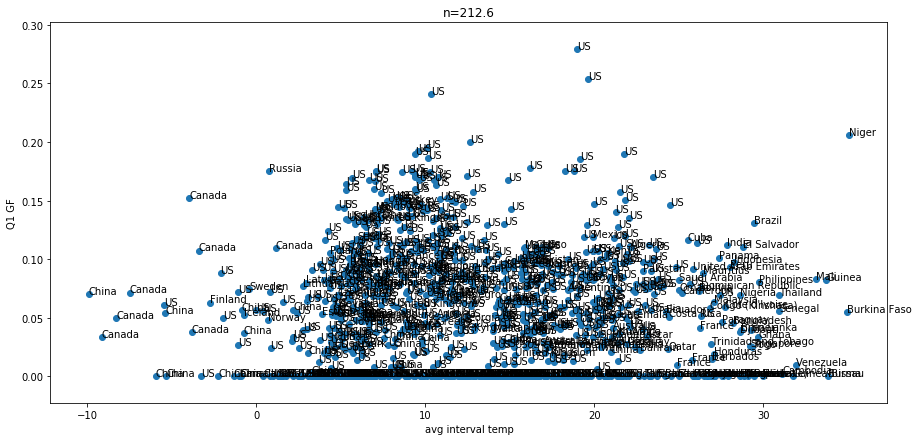

In [34]:
TMP_RATE = 1
RH_RATE = 1

confs1 = hopkins_confirmed[['Country_Region', 'avg_interval_tmp',\
                            'avg_interval_RH', 'GF_Q1', 'GF_Q2', 'GF_Q3', 'first_7']].dropna()
confs1['avg_interval_tmp'] = confs1['avg_interval_tmp'] * TMP_RATE
confs1['avg_interval_RH'] = confs1['avg_interval_RH'] * RH_RATE

conf_corrs_p1 = confs1.corr().unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_p1 = conf_corrs_p1[conf_corrs_p1 != 1]
_ = conf_corrs_p1.drop_duplicates()
print('\nInetrval temp correaltion Pearson')
print(conf_corrs_p1['avg_interval_tmp'])

conf_corrs_s1 = confs1.corr('spearman').unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_s1 = conf_corrs_s1[conf_corrs_s1 != 1]
_ = conf_corrs_s1.drop_duplicates()
print('\nInetrval temp correaltion Spearman')
print(conf_corrs_s1['avg_interval_tmp'])

gf_q1_1 = confs1['GF_Q1'].loc[:,'data'].values.tolist()
avg_int_tmp1 = confs1['avg_interval_tmp'].loc[:,'data'].values.tolist()

fig, axes = plt.subplots(figsize=(15, 7))
_ = axes.scatter(avg_int_tmp1, gf_q1_1)
n = len(confs1) / 5 # five entries for each index

_ = axes.set_xlabel('avg interval temp')
_ = axes.set_ylabel('Q1 GF')
_ = axes.set_title('n={0}'.format(n))

countries1 = confs1['Country_Region'].loc[:,'data'].values.tolist()

for i, txt in enumerate(countries1):
    _ = axes.annotate(txt, (avg_int_tmp1[i], gf_q1_1[i]))


Significant correlations with p-values:

In [17]:
corr_1 = stats.pearsonr(gf_q1_1, avg_int_tmp1)
print('GF_Q1 vs avg_interval_tmp correaltion Pearson: {0}, p-value: {1}'.format(corr_1[0], corr_1[1]))

corr_1 = stats.spearmanr(gf_q1_1, avg_int_tmp1)
print('GF_Q1 vs avg_interval_tmp correaltion Spearman: {0}, p-value: {1}'.format(corr_1[0], corr_1[1]))


GF_Q1 vs avg_interval_tmp correaltion Pearson: -0.015010554817148464, p-value: 0.6238071622938999
GF_Q1 vs avg_interval_tmp correaltion Spearman: -0.009339651349389706, p-value: 0.7602461709810644


###### Correlations of case studies


Inetrval temp correaltion Pearson
first_7           -0.092119
GF_Q3             -0.296945
GF_Q2             -0.301468
avg_interval_RH   -0.361063
GF_Q1             -0.419656
dtype: float64

Inetrval temp correaltion Spearman
first_7           -0.139169
avg_interval_RH   -0.182595
GF_Q2             -0.307350
GF_Q3             -0.354530
GF_Q1             -0.436023
dtype: float64


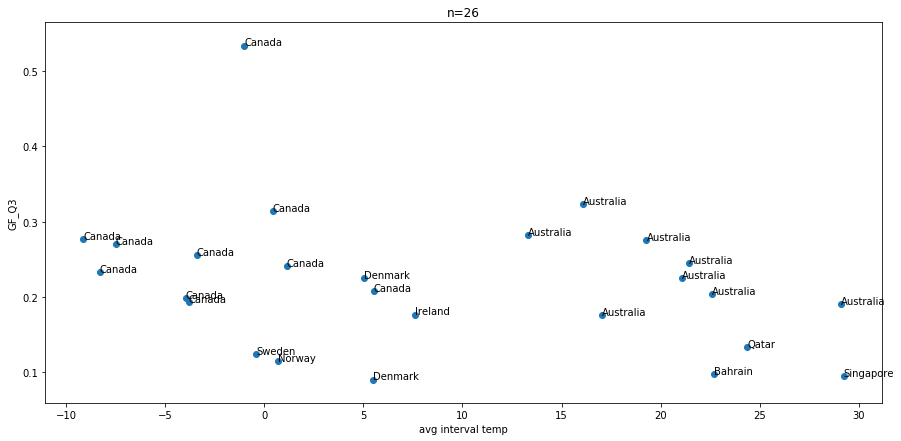

In [35]:
cold = ['Sweden', 'Norway', 'Canada', 'Ireland', 'Denmark']
hot = ['Australia', 'Taiwan*', 'Singapore', 'Qatar', 'Bahrain']

confs2 = hopkins_confirmed[hopkins_confirmed['Country_Region'].isin(hot + cold)]\
        [['Country_Region', 'avg_interval_tmp', 'avg_interval_RH', 'GF_Q1', 'GF_Q2', 'GF_Q3', 'first_7']]


conf_corrs_p2 = confs2.corr().unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_p2 = conf_corrs_p2[conf_corrs_p2 != 1]
_ = conf_corrs_p2.drop_duplicates()
print('\nInetrval temp correaltion Pearson')
print(conf_corrs_p2['avg_interval_tmp'])

conf_corrs_s2 = confs2.corr('spearman').unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_s2 = conf_corrs_s2[conf_corrs_s2 != 1]
_ = conf_corrs_s2.drop_duplicates()
print('\nInetrval temp correaltion Spearman')
print(conf_corrs_s2['avg_interval_tmp'])

gf_q3_2 = confs2['GF_Q3'].loc[:,'data'].values.tolist()
avg_int_tmp2 = confs2['avg_interval_tmp'].loc[:,'data'].values.tolist()

first_7_2 = confs2['first_7'].loc[:,'data'].values
# first_7_2 = np.nan_to_num(first_7_2, nan=np.nanmean(first_7_2))

fig, axes = plt.subplots(figsize=(15, 7))
_ = axes.scatter(avg_int_tmp2, gf_q3_2)
n = len(confs2)

_ = axes.set_xlabel('avg interval temp')
_ = axes.set_ylabel('GF_Q3')
_ = axes.set_title('n={0}'.format(n))

countries2 = confs2['Country_Region'].loc[:,'data'].values.tolist()

for i, txt in enumerate(countries2):
    _ = axes.annotate(txt, (avg_int_tmp2[i], gf_q3_2[i]))


In [20]:
corr_2 = stats.pearsonr(gf_q3_2, avg_int_tmp2)
print('GF_Q3 vs avg_interval_tmp correaltion Pearson: {0}, p-value: {1}'.format(corr_2[0], corr_2[1]))

corr_2 = stats.spearmanr(gf_q3_2, avg_int_tmp2)
print('GF_Q3 vs avg_interval_tmp correaltion Spearman: {0}, p-value: {1}'.format(corr_2[0], corr_2[1]))


GF_Q3 vs avg_interval_tmp correaltion Pearson: -0.29694485869727977, p-value: 0.1407174136268022
GF_Q3 vs avg_interval_tmp correaltion Spearman: -0.3545299145299145, p-value: 0.07555429353027408


###### Rank sum
We regard two groups - 'cold' and 'hot' groups.
Each group's score is it's Q3 infection rate.
We will perform a Wilcoxon rank test and get a p-value for this arrangment

In [6]:
cold = ['Sweden', 'Norway', 'Canada', 'Ireland', 'Denmark']
hot = ['Australia', 'Taiwan*', 'Singapore', 'Qatar', 'Bahrain']
colds = hopkins_confirmed[hopkins_confirmed['Country_Region'].isin(cold)]\
        [['Country_Region', 'avg_interval_tmp', 'GF_Q3']]
hots = hopkins_confirmed[hopkins_confirmed['Country_Region'].isin(hot)]\
        [['Country_Region', 'avg_interval_tmp', 'GF_Q3']]

# colds
# hots

In [198]:
def remove_outlier(df, range_, columns):
    low = range_[0]
    high = range_[1]
    qnt = df.quantile([low, high])
    data = df.copy()
    for col in list(columns):
        data[col] = \
            data[(data[col] > qnt.loc[low, col]) &\
               (data[col] < qnt.loc[high, col])][col]
    return data
col = ['GF_Q1', 'GF_Q3']
range_=(0.02,0.98)
# data = remove_outlier(hopkins_confirmed,range_, [col])

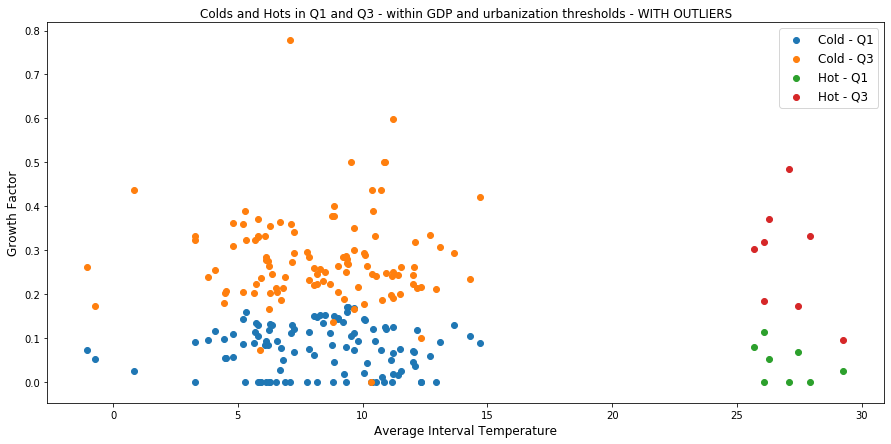

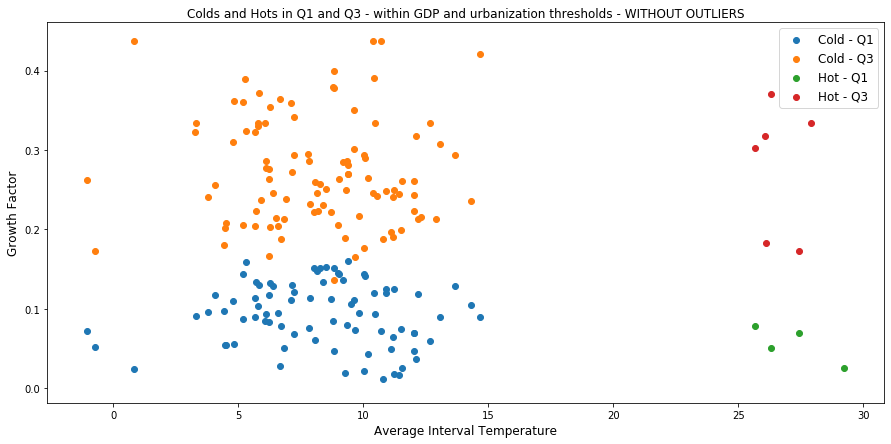

In [243]:
gdp_th = 43000
urban_th = 88

colds = hopkins_confirmed[hopkins_confirmed['avg_interval_tmp'] <= 15][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
# print(colds.head())
colds = colds[colds['GDP'] > gdp_th]
colds = colds[colds['Urbanization'] > urban_th]


hots = hopkins_confirmed[hopkins_confirmed['avg_interval_tmp'] >= 25][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
hots = hots[hots['GDP'] >= gdp_th][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]
hots = hots[hots['Urbanization'] >= urban_th][['Country_Region', 'avg_interval_tmp','GF_Q1', 'GF_Q3', 'GDP', 'Urbanization']]


colds.reset_index(level=[0,1], drop=True, inplace=True)
hots.reset_index(level=[0,1], drop=True, inplace=True)

fig, axes = plt.subplots(figsize=(15, 7))
axes.scatter(colds['avg_interval_tmp'], colds['GF_Q1'])
axes.scatter(colds['avg_interval_tmp'], colds['GF_Q3'])
axes.scatter(hots['avg_interval_tmp'], hots['GF_Q1'])
axes.scatter(hots['avg_interval_tmp'], hots['GF_Q3'])

axes.set_xlabel('Average Interval Temperature', fontsize='large')
axes.set_ylabel('Growth Factor', fontsize='large')
axes.set_title('Colds and Hots in Q1 and Q3 - within GDP and urbanization thresholds - WITH OUTLIERS'.format(n))
axes.legend(['Cold - Q1', 'Cold - Q3', 'Hot - Q1', 'Hot - Q3'], fontsize='large')
# axes.text(7,  1.5556, 'Nebraska', fontsize='large')
# axes.text(9,  1.8571, 'Iowa', fontsize='large')
# plt.text(2,4,'This text starts at point (2,4)')

# colds_no_outliers = colds[colds['GF_Q3'] > 0.01]
# colds_no_outliers = colds[colds['GF_Q3'] < 1.25]

# without outliers
colds_no_outliers = remove_outlier(colds,range_, [col])
hots_no_outliers = remove_outlier(hots,range_, [col])

fig, axes = plt.subplots(figsize=(15, 7))
axes.scatter(colds_no_outliers['avg_interval_tmp'], colds_no_outliers['GF_Q1'])
axes.scatter(colds_no_outliers['avg_interval_tmp'], colds_no_outliers['GF_Q3'])
axes.scatter(hots_no_outliers['avg_interval_tmp'], hots_no_outliers['GF_Q1'])
axes.scatter(hots_no_outliers['avg_interval_tmp'], hots_no_outliers['GF_Q3'])




axes.set_xlabel('Average Interval Temperature', fontsize='large')
axes.set_ylabel('Growth Factor', fontsize='large')
axes.set_title('Colds and Hots in Q1 and Q3 - within GDP and urbanization thresholds - WITHOUT OUTLIERS'.format(n))
axes.legend(['Cold - Q1', 'Cold - Q3', 'Hot - Q1', 'Hot - Q3'], fontsize='large')

In [ ]:
i

### WRS - Manual and Built-In

In [217]:
# colds = hopkins_confirmed[hopkins_confirmed['avg_interval_tmp'] <= 15]\
#         [['GF_Q1']]

# hots = hopkins_confirmed[hopkins_confirmed['avg_interval_tmp'] >= 25]\
#         [['GF_Q1']]

# colds.reset_index(level=[0,1], drop=True, inplace=True)
# hots.reset_index(level=[0,1], drop=True, inplace=True)

# colds_ranksum = colds
# hots_ranksum = hots

# colds.reset_index(level=[0,1], drop=True, inplace=True)
# hots.reset_index(level=[0,1], drop=True, inplace=True)

# def manual_WRS(colds, hots, gf_qx):


def manual_WRS(gf_qx, df):

    colds = df[df['avg_interval_tmp'] <= 15]\
        [[gf_qx]]

    hots = df[df['avg_interval_tmp'] >= 25]\
        [[gf_qx]]

    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)

    colds.rename(columns={gf_qx: ''}, inplace=True)
    hots.rename(columns={gf_qx: ''}, inplace=True)

    # manual WRS algorithm

    colds = colds.T
    hots = hots.T
    colds = colds.add_prefix('c')
    hots = hots.add_prefix('h')
    ranks = colds.join(hots, lsuffix='first').rank(axis=1)
    
    h_list = [sample for sample in ranks.columns if 'h' in sample]
    c_list = [sample for sample in ranks.columns if 'c' in sample]
    h_sum = ranks[h_list].sum(axis=1)
    c_sum = ranks[c_list].sum(axis=1)

    b = len(colds.columns)
    n = b + len(hots.columns)
    expected_cold_sum = (b * (n + 1)) / 2
    sigma = math.sqrt(b * (n - b) * (n + 1) / 12)

    sums_normal = stats.norm(loc=expected_cold_sum, scale=sigma)
    p_value = 1 - sums_normal.cdf(float(c_sum))
    
    return [expected_cold_sum, c_sum, p_value, sigma]

def print_manual_WRS(qx, qx_results):
    difference = qx_results[1] - qx_results[0]
    print('--------------------------------------------------')
    print('{} WRS (manual)'.format(qx))
    print('--------------------------------------------------')
    print('Expected mean for cold countries rank sum: {0}\n'
     'Attained mean for cold countries rank sum: {1}\n'
     'Sigma: {4}\n'
     '(Attained mean) - (Expected mean) = {3}\n'
     'p-value for this result is: {2}'.format(qx_results[0], qx_results[1], qx_results[2], difference, qx_results[3]))
# print('--------------------------------------------------\n')



# built-in python WRS function
def builtin_WRS(gf_qx, df):
    colds = df[df['avg_interval_tmp'] <= 15][gf_qx]
    hots = df[df['avg_interval_tmp'] >= 25][gf_qx]
    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)
    t, p = stats.ranksums(colds, hots)
    return [t, p/2]




def print_builtin_WRS(qx, qx_results):
    print('--------------------------------------------------')
    print('{} WRS (built-in) '.format(qx))
    print('--------------------------------------------------')
    print('Statistic: {0}'.format(qx_results[0]))
    print('p-value: {0}'.format(qx_results[1]))
#     print('--------------------------------------------------')







### T-test (built-in)

In [218]:
def builtin_ttest(gf_qx, df):
    colds = df[df['avg_interval_tmp'] <= 15][gf_qx]
    hots = df[df['avg_interval_tmp'] >= 25][gf_qx]
    colds.reset_index(level=[0,1], drop=True, inplace=True)
    hots.reset_index(level=[0,1], drop=True, inplace=True)
    t, p = stats.ttest_ind(colds, hots)
    return [t, p/2]


def print_builtin_ttest(qx, qx_results):
    print('--------------------------------------------------')
    print('{} TTest (built-in)'.format(qx))
    print('--------------------------------------------------')
    print('Statistic: {0}'.format(qx_results[0]))
    print('p-value: {0}'.format(qx_results[1]))
    print('--------------------------------------------------')

    




In [233]:

hopkins_gdp_urban_th = hopkins_confirmed[hopkins_confirmed['GDP'] >= gdp_th]
hopkins_gdp_urban_th = hopkins_gdp_urban_th[hopkins_gdp_urban_th['Urbanization'] >= urban_th]
hopkins_without_outliers = remove_outlier(hopkins_confirmed, range_, [col])

def calc_wrs_ttest(df):
    Q1_manual = manual_WRS('GF_Q1', df)
    print_manual_WRS('Q1', Q1_manual)

    Q1_builtin = builtin_WRS('GF_Q1', df)
    print_builtin_WRS('Q1', Q1_builtin)
    
    Q1_ttest = builtin_ttest('GF_Q1', df)
    print_builtin_ttest('Q1', Q1_ttest)
    
    Q3_manual = manual_WRS('GF_Q3', df)
    print_manual_WRS('Q3', Q3_manual)

    Q3_builtin = builtin_WRS('GF_Q3', df)
    print_builtin_WRS('Q3', Q3_builtin)

    Q3_ttest = builtin_ttest('GF_Q3', df)
    print_builtin_ttest('Q3', Q3_ttest)



In [234]:
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITH OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_confirmed)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITH OUTLIERS
--------------------------------------------------
--------------------------------------------------
Q1 WRS (manual)
--------------------------------------------------
Expected mean for cold countries rank sum: 239250.0
Attained mean for cold countries rank sum:     242606.5
dtype: float64
Sigma: 1597.4980438172686
(Attained mean) - (Expected mean) =     3356.5
dtype: float64
p-value for this result is: 0.01781618070505575
--------------------------------------------------
Q1 WRS (built-in) 
--------------------------------------------------
Statistic: 2.1010980345112316
p-value: 0.017816180705055733
--------------------------------------------------
Q1 TTest (built-in)
--------------------------------------------------
Statistic: 2.293670128509361
p-value: 0.011047925654980919
--------------------------------------------------
--------------------

In [235]:
print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHOUT OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_without_outliers)




--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHOUT OUTLIERS
--------------------------------------------------
--------------------------------------------------
Q1 WRS (manual)
--------------------------------------------------
Expected mean for cold countries rank sum: 239250.0
Attained mean for cold countries rank sum:     118513.5
dtype: float64
Sigma: 1597.4980438172686
(Attained mean) - (Expected mean) =    -120736.5
dtype: float64
p-value for this result is: 1.0
--------------------------------------------------
Q1 WRS (built-in) 
--------------------------------------------------
Statistic: 1.4575917692117988
p-value: 0.07247654984737571
--------------------------------------------------
Q1 TTest (built-in)
--------------------------------------------------
Statistic: nan
p-value: nan
--------------------------------------------------
--------------------------------------------------
Q3 WRS (man

In [236]:
print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITH OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_gdp_urban_th)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITH OUTLIERS
--------------------------------------------------
--------------------------------------------------
Q1 WRS (manual)
--------------------------------------------------
Expected mean for cold countries rank sum: 7371.0
Attained mean for cold countries rank sum:     7550.0
dtype: float64
Sigma: 99.13626985114983
(Attained mean) - (Expected mean) =     179.0
dtype: float64
p-value for this result is: 0.03549077520164401
--------------------------------------------------
Q1 WRS (built-in) 
--------------------------------------------------
Statistic: 1.8055954724619272
p-value: 0.035490775201643975
--------------------------------------------------
Q1 TTest (built-in)
--------------------------------------------------
Statistic: 1.793167043226482
p-value: 0.03770182014580103
------------------------------------------------

In [240]:
hopkins_gdp_urban_th_no_outliers = remove_outlier(hopkins_gdp_urban_th, range_, [col])

print()
print('--------------------------------------------------')
print('--------------------------------------------------')
print("WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITHOUT OUTLIERS")
print('--------------------------------------------------')

calc_wrs_ttest(hopkins_gdp_urban_th_no_outliers)


--------------------------------------------------
--------------------------------------------------
WRS and TTEST for data WITHIN GDP URBAN THRESHOLDS, WITHOUT OUTLIERS
--------------------------------------------------
--------------------------------------------------
Q1 WRS (manual)
--------------------------------------------------
Expected mean for cold countries rank sum: 7371.0
Attained mean for cold countries rank sum:     4412.0
dtype: float64
Sigma: 99.13626985114983
(Attained mean) - (Expected mean) =    -2959.0
dtype: float64
p-value for this result is: 1.0
--------------------------------------------------
Q1 WRS (built-in) 
--------------------------------------------------
Statistic: 0.6556631603912026
p-value: 0.25602043855956796
--------------------------------------------------
Q1 TTest (built-in)
--------------------------------------------------
Statistic: nan
p-value: nan
--------------------------------------------------
----------------------------------------

print(expected_cold_sum)
print(c_sum)
print(sigma)

###### Correlations with GDP and Urbanisation normalization

In [92]:
avg_int_tmp_3[2], gf_q1_3[2]

NameError: name 'avg_int_tmp_3' is not defined

Locations in entire dataset: 1070.0
Location after thresholds: 1063

Inetrval temp correaltion Pearson
GF_Q3              0.053312
GF_Q2              0.025432
first_7           -0.025615
GF_Q1             -0.026928
avg_interval_RH   -0.048916
dtype: float64

Inetrval temp correaltion Spearman
GF_Q3              0.062942
GF_Q2              0.020974
avg_interval_RH    0.018113
GF_Q1             -0.012499
first_7           -0.034133
dtype: float64


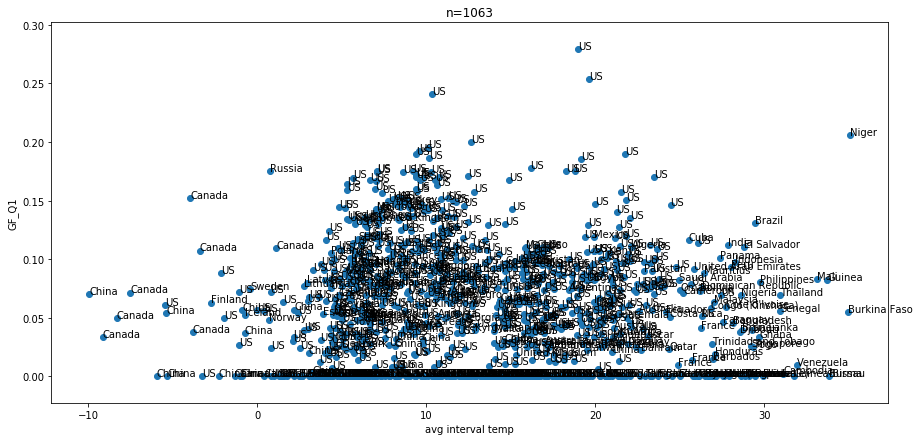

In [103]:
# hopkins_confirmed[hopkins_confirmed['Country_Region'].isin(['Australia', 'US', 'Israel', 'France'])]\
#                                     [['Country_Region', 'GDP', 'Urbanization']]
# gdp_mean = np.nanmean(hopkins_confirmed['GDP'].loc[:,'data'].values) 
# urb_mean = np.nanmean(hopkins_confirmed['Urbanization'].loc[:,'data'].values) 

GDP_THRESHOLD = 0
URB_THRESHOLD = 0
    # MEAN   - 22914, 67
    # USA    - 62794, 82
    # ISRAEL - 41715, 92
    # FRANCE - 41463, 80

confs3 = hopkins_confirmed[hopkins_confirmed['GDP'] > GDP_THRESHOLD]\
                        [hopkins_confirmed['Urbanization'] > URB_THRESHOLD]\
                        [['Country_Region', 'avg_interval_tmp', 'avg_interval_RH',\
                          'GF_Q1', 'GF_Q2', 'GF_Q3', 'first_7']].dropna()
    
print('Locations in entire dataset: {0}\n'
      'Location after thresholds: {1}'.format(len(hopkins_confirmed) / 5, len(confs3)))

conf_corrs_p3 = confs3.corr().unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_p3 = conf_corrs_p3[conf_corrs_p3 != 1]
_ = conf_corrs_p3.drop_duplicates()
print('\nInetrval temp correaltion Pearson')
print(conf_corrs_p3['avg_interval_tmp'])

conf_corrs_s3 = confs3.corr('spearman').unstack().sort_values(kind="quicksort", ascending=False)
conf_corrs_s3 = conf_corrs_s3[conf_corrs_s3 != 1]
_ = conf_corrs_s3.drop_duplicates()
print('\nInetrval temp correaltion Spearman')
print(conf_corrs_s3['avg_interval_tmp'])

gf_q1_3 = confs3['GF_Q1'].loc[:,'data'].values.tolist()
avg_int_tmp_3 = confs3['avg_interval_tmp'].loc[:,'data'].values.tolist()

first_7_3 = confs3['first_7'].loc[:,'data'].values
first_7_3 = np.nan_to_num(first_7_3) #, nan=np.nanmean(first_7_3))

fig, axes = plt.subplots(figsize=(15, 7))
_ = axes.scatter(avg_int_tmp_3, gf_q1_3)
n = len(confs3)

_ = axes.set_xlabel('avg interval temp')
_ = axes.set_ylabel('GF_Q1')
_ = axes.set_title('n={0}'.format(n))

countries3 = confs3['Country_Region'].loc[:,'data'].values.tolist()

for i, txt in enumerate(countries3):
    _ = axes.annotate(txt, (avg_int_tmp_3[i], gf_q1_3[i]))


Significant correlations with p-values

In [303]:
corr_3 = stats.pearsonr(gf_q1_3, avg_int_tmp_3)
print('GF_Q1 vs avg_interval_tmp correaltion Pearson: {0}, p-value: {1}'.format(corr_3[0], corr_3[1]))

corr_3 = stats.spearmanr(gf_q1_3, avg_int_tmp_3)
print('GF_Q1 vs avg_interval_tmp correaltion Spearman: {0}, p-value: {1}'.format(corr_3[0], corr_3[1]))


GF_Q1 vs avg_interval_tmp correaltion Pearson: -0.26279370436910104, p-value: 0.08114753772707378
GF_Q1 vs avg_interval_tmp correaltion Spearman: -0.25335698689075775, p-value: 0.09310004401088315


###### Linear regression

In [ ]:
a